In [1]:
import os
from dotenv import load_dotenv
import warnings
import pickle

warnings.filterwarnings('ignore')
load_dotenv()

# 필수 라이브러리 로드
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
import time

In [2]:
# 이전 단계 데이터 로드 또는 재생성
print('청크데이터 로드')
chunks_file = 'chunk_output.pkl'

if os.path.exists(chunks_file):
    with open(chunks_file, 'rb') as f:     # 파일 불러온 걸 볼 때는 rb
        doc_chunks = pickle.load(f)        # 피클 파일 열때는 load
else :
    # 파일이 없으면 새로 생성
    print('5_1.ipynb')

# openai 임베딩 모델 초기화
embedding_model = OpenAIEmbeddings(
    model = 'text-embedding-3-small'
)


청크데이터 로드


In [3]:
# 단일 텍스트 임베딩 텍스트
test_text = 'RAG는 검색 증강 생성 기술입니다'

start_time = time.time()
test_embedding = embedding_model.embed_query(test_text)
elapsed = time.time() - start_time
print(f'입력텍스트 : {test_text}')
print(f'벡터차원 : {len(test_embedding)}')
print(f'벡터일부 : {test_embedding[0]:.4f}, {test_embedding[1]:.4f}... {test_embedding[-1]:.4f}')
print(f'소요시간 : {elapsed:.3f}')


입력텍스트 : RAG는 검색 증강 생성 기술입니다
벡터차원 : 1536
벡터일부 : 0.0135, 0.0530... -0.0635
소요시간 : 1.529


In [4]:
# 유사도 계산
import numpy as np
def cosine_similarity(vec1, vec2):      # 코사인 유사도는 1에 가까울수록 유사
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)        # linalg: 넘파이에서 벡터 길이를 구하는 함수
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1*norm2)

In [5]:
test_sentences = [
    "RAG는 검색 증강 생성 기술입니다.",         # 기준 문장
    "RAG는 문서 검색과 답변 생성을 결합합니다.",  # 유사한 문장
    "벡터 데이터베이스는 임베딩을 저장합니다.",   # 관련 있는 문장
    "오늘 날씨가 매우 좋습니다.",               # 관련 없는 문장
]

# 모든 문장을 임베딩
embeddings = [embedding_model.embed_query(sent) for sent in test_sentences]
# 기존 문장과 유사도 비교
base_embedding = embeddings[0]  #  "RAG는 검색 증강 생성 기술입니다."   # 기준 문장 을 뜻함
print(f'기존 문장 : {test_sentences}')
print(f'유사도 비교 결과')
for i,(sent, emb) in enumerate(zip(test_sentences[1:],embeddings[1:]), 1):
    similarity = cosine_similarity(base_embedding,emb)
    print(f' 문서{i}번째 {sent[:30]} --> {similarity:.4f}')

# 위에 test_sentences 중 기준 문장과 나머지 3개 문장의 유사도를 측정하는 것
# 코사인유사도는 값이 클수록 유사

기존 문장 : ['RAG는 검색 증강 생성 기술입니다.', 'RAG는 문서 검색과 답변 생성을 결합합니다.', '벡터 데이터베이스는 임베딩을 저장합니다.', '오늘 날씨가 매우 좋습니다.']
유사도 비교 결과
 문서1번째 RAG는 문서 검색과 답변 생성을 결합합니다. --> 0.6779
 문서2번째 벡터 데이터베이스는 임베딩을 저장합니다. --> 0.2335
 문서3번째 오늘 날씨가 매우 좋습니다. --> 0.0665


---

<span style="color: Gold"> Chroma DB

- 문서, 텍스트, 이미지 등 임베딩(벡터) 데이터를 저장하고, 유사도 검색을 빠르게 수행하는 데이터베이스
   -  입력: 텍스트 → 임베딩 벡터로 변환
   -  저장: 벡터 + 메타데이터(출처, 태그 등)
   -  검색: 벡터 기반 유사도 검색 → 가장 유사한 문서/데이터 반환

In [ ]:
# Chroma DB 벡터DB
# 동작방식
# 저장 : 텍스트(청크) -> 임베딩(벡터) -> VectorDB(저장)
# 검색: 질문 -> 임베딩(벡터) -> 유사도검색 -> top-k 문서 반환

# chroma DB 청크 저장
start_time = time.time()
# chromaDB 생성(인메모리 방식)   
vectorstore = Chroma.from_documents(    # chroma db는 벡터화되지 않은 문서도 자동으로 벡터화해줌/ 벡터화되지 않은 건 from_documents, 벡터화된건 from_embeddings 으로 해야됨
    documents = doc_chunks,             # 피클 파일 로드/ 
    collection_name = '5_1.ipynb',
    embedding = embedding_model,
)
elapsed = time.time() - start_time
print(f'VectorDB 구축완료')
print(f'저장된 청크 수 :{len(doc_chunks)}')
print(f'소요시간 :{elapsed:.2f}')

VectorDB 구축완료
저장된 청크 수 :10
소요시간 :1.93


In [7]:
# 테스트 질문
test_queries = [
    'RAG란 무엇인가요?',
    'VectorDB에는 어떤 종류가 있나요?',
    'LangChain의 구성 요소는'
]
for query in test_queries:
    print(f'질문: {query}')
    # 유사문서 검색 상위 2개
    results = vectorstore.similarity_search_with_score(query,k=2)   # similarity_search_with_scores는 거리기반이기 떄문에 숫자가 낮을수록 유사
    for i,(doc,score) in enumerate(results, 1):
        source = doc.metadata.get('source','unknown')
        preview = doc.page_content.strip()[:80].replace('\n',' ' )
        print(f'{i}{source} (거리:{score:.4f})')
        print(f'   {preview}')

질문: RAG란 무엇인가요?
1rag_concept.txt (거리:0.8408)
   RAG의 핵심 구성요소: Retriever(검색기), Generator(생성기), VectorStore(벡터저장소)
2rag_concept.txt (거리:0.8725)
   RAG (Retrieval-Augmented Generation)는 검색 증강 생성 기술입니다.          RAG의 작동 원리:      
질문: VectorDB에는 어떤 종류가 있나요?
1vectordb_intro.txt (거리:0.6636)
   VectorDB(벡터 데이터베이스)는 고차원 벡터를 효율적으로 저장하고 검색하는 데이터베이스입니다.
2vectordb_intro.txt (거리:1.1472)
   주요 VectorDB 솔루션:         - ChromaDB: 로컬 개발에 적합한 오픈소스 솔루션. 파이썬 네이티브로 설치가 간편합니다.  
질문: LangChain의 구성 요소는
1langchain_intro.txt (거리:0.6945)
   LangChain의 주요 구성 요소:         1. Models: 다양한 LLM 제공자(OpenAI, Anthropic, Google 등)
2langchain_intro.txt (거리:0.8203)
   LangChain은 대규모 언어 모델(LLM)을 활용한 애플리케이션 개발을 위한 프레임워크입니다.


---

<span style="color: Gold"> 리트리버 : 벡터DB에 있는 청크(문서)를 검색하는 역할

In [ ]:
# 다양한 검색 옵션
print('다양한 검색 옵션')
# 리트리버 생성
print('기본 유사도 검색(similarity)')
retriver_basic = vectorstore.as_retriever(
    search_type = 'similarity', # search_type 종류는 similarity/ mmr(관련성이 높은 것)/ similarity_score_threschold
    search_kwargs = {'k' :3}    # 가장 유사한 문서를 k개만큼 반환
)
results = retriver_basic.invoke('RAG의 장점')
print(f'결과 수 : {len(results)}개')
for i,doc in enumerate(results, 1):
    print(f'{i}{doc.metadata.get('source''unknown')}')





print(F'MMR 검색(다양성 고려)')
retriver_basic = vectorstore.as_retriever(
    search_type = 'mmr', # mmr 작동방식 : 먼저 유사한 fetch_k개 만큼 가져오고, 이 문서들 중 질문과 유사하면서도 이미 선택된 다른 문서와는 유사하지 않은 문서를 k개 만큼 골라냄
    search_kwargs = {'k' :3,
                  'fetch_k': 6, # 먼저 6개의 후보 검색
                  'lambda_mult':0.5 # 다양성 가중치(0 = 다양성, 1 = 관련성)
    }
)
results = retriver_basic.invoke('RAG의 장점')
print(f'결과 수 : {len(results)}개')
for i, doc in enumerate(results, 1):
    print(f'    {i} {doc.metadata.get('source','unknown')}')




print('메타데이터 필터링')
results = vectorstore.similarity_search(
    '기술에 대해 설명해 주세요',
    k=2,
    filter = {'topic':'technique'}  # 문서 metadata에 topic 중 technique만 검색할 수 있도록 필터링
)
print(f'결과 수 : {len(results)}개')
for i,doc in enumerate(results, 1):
    print(f'{i}{doc.metadata.get('source''unknown')}topic = {doc.metadata.get('topic')}')

다양한 검색 옵션
기본 유사도 검색(similarity)
결과 수 : 3개
1None
2None
3None
MMR 검색(다양성 고려)
결과 수 : 3개
    1 rag_concept.txt
    2 rag_concept.txt
    3 langchain_intro.txt
메타데이터 필터링
결과 수 : 2개
1Nonetopic = technique
2Nonetopic = technique


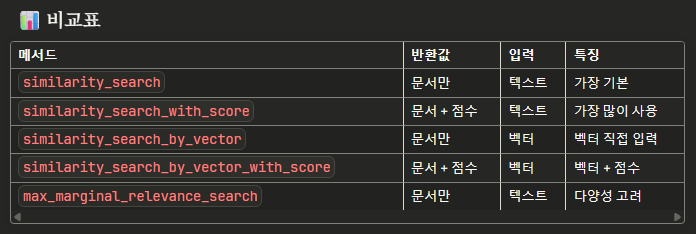

In [ ]:
# VectorDB 영구 저장(옵션)
persist_dir = './chroma_db_rag2'
vectorstore_persistent =  Chroma.from_documents(
    documents = doc_chunks,
    collection_name = 'persistent_rag',
    embedding = embedding_model,
    persist_directory = persist_dir)

print('vectordb 영구저장')
print(f'저장경로 : {persist_dir}')
print(f'저장된 청크수 : {len(doc_chunks)}')

# 설정정보 저장
config = {
    'persist_directory' : persist_dir,
    'collection_name': "persistent_rag",
    'embedding_model' : 'text-embedding-',
    'chunk_count' : len(doc_chunks)
}
with open('vectordb_config.pkl','wb')as f:
    pickle.dump(config,f)

print('설정정보 저장 완료 파일명 : vectordb_config.pkl')

vectordb 영구저장
저장경로 : ./chroma_db_rag2
저장된 청크수 : 10
설정정보 저장 완료 파일명 : vectordb_config.pkl
